In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline

In [2]:
load_dir = Path('../2_pipeline').resolve()
model_name = '15_Final_Model_Training'

nw_dir = load_dir.joinpath('12d_Preprocessing-Abbreviations_and_Biolink', 'out')
hyp_dir = load_dir.joinpath('13c_Model_Prep_Hyperparam_tuning', 'out')
model_dir = load_dir.joinpath(model_name, 'out')

In [3]:
this_name = '16e_Model_results_analysis_alzheimers'
out_dir = load_dir.joinpath(this_name, 'out')

out_dir.mkdir(exist_ok=True, parents=True)

In [4]:
nodes = pd.read_csv(nw_dir.joinpath('nodes_biolink.csv'), dtype=str)
edges = pd.read_csv(nw_dir.joinpath('edges_biolink.csv'), dtype=str)

In [5]:
best_param = pickle.load(open(hyp_dir.joinpath('best_param.pkl'), 'rb'))

In [6]:
from hetnet_ml.extractor import MatrixFormattedGraph
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', 'Disease', max_length=4, w=best_param['w'], n_jobs=30)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|██████████| 68/68 [00:56<00:00,  1.21it/s]



Determining degrees for each node and metaedge


100%|██████████| 68/68 [00:27<00:00,  2.51it/s]



Weighting matrices by degree with dampening factor 0.5665616931869023...


100%|██████████| 68/68 [00:00<00:00, 131.17it/s]


In [7]:
model = pickle.load(open(model_dir.joinpath('model.pkl'), 'rb'))

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
res = pd.read_csv(model_dir.joinpath('results.csv'))
coef = pd.read_csv(model_dir.joinpath('coef.csv'))
len(res)

90996724

In [9]:
metapaths = coef.query('feature != "intercept"')['feature'].tolist()

In [10]:
from data_tools.graphs import dataframes_to_metagraph, metapaths_to_json
metagraph = dataframes_to_metagraph(nodes, edges)

all_metapaths = metagraph.extract_metapaths('ChemicalSubstance', 'Disease', 4)
mp_info = {mp.abbrev: mp for mp in all_metapaths if mp.abbrev in metapaths}

In [11]:
len(res)

85126262

In [11]:
id_to_name = nodes.set_index('id')['name'].to_dict()
res['chem_name'] = res['chemicalsubstance_id'].map(id_to_name)
res['dis_name'] = res['disease_id'].map(id_to_name)
res = res.sort_values('proba', ascending=False).reset_index(drop=True)

res.head(2)

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
0,CHEBI:53769,MONDO:0005399,0,0.997371,(S)-acenocoumarol,venous thromboembolism
1,CHEBI:50438,MONDO:0005399,0,0.997320,phenprocoumon,venous thromboembolism


In [12]:
def find_nodes_by_name(sub_str, n_type=None):
    if n_type is not None:
        qr = nodes.query('label == @n_type')   
    else:
        qr = nodes
    
    return qr[qr['name'].str.contains(sub_str)]

In [13]:
nodes['name'] = nodes['name'].fillna('')

In [14]:
find_nodes_by_name('lzheimer', n_type='Disease')

,id,name,label,xrefs,source,synonyms,alt_ids,subsets
69824,DOID:0080348,Alzheimer's disease 1,Disease,DOID:0080348|OMIM:104300,NaN,"Alzheimer's disease 1, early onset",NaN,NaN
70272,DOID:0110035,Alzheimer's disease 2,Disease,DOID:0110035|ICD10CM:G30|MESH:C536595|MONDO:00...,NaN,"AD2|Alzheimer disease 2, late onset|Alzheimer ...",NaN,NaN
70273,DOID:0110036,Alzheimer's disease 16,Disease,DOID:0110036|MONDO:0010422|OMIM:300756|UMLS:C2...,NaN,"AD16|Alzheimer's disease 16, late onset",NaN,NaN
70274,DOID:0110037,Alzheimer's disease 5,Disease,DOID:0110037|ICD10CM:G30|MESH:C566578|MONDO:00...,NaN,"AD5|Alzheimer disease 5|Alzheimer disease, fam...",NaN,NaN
70275,DOID:0110038,Alzheimer's disease 6,Disease,DOID:0110038|ICD10CM:G30|MESH:C565325|MONDO:00...,NaN,"AD6|Alzheimer disease 6|Alzheimer disease 6, l...",NaN,NaN
70276,DOID:0110039,Alzheimer's disease 7,Disease,DOID:0110039|ICD10CM:G30|MESH:C565251|MONDO:00...,NaN,"AD7|Alzheimer disease 7|Alzheimer disease, fam...",NaN,NaN
70277,DOID:0110040,Alzheimer's disease 4,Disease,DOID:0110040|MESH:C536596|MONDO:0011743|OMIM:6...,NaN,"AD4|Alzheimer disease 4|Alzheimer disease, fam...",NaN,NaN
70278,DOID:0110041,Alzheimer's disease 8,Disease,DOID:0110041|ICD10CM:G30|MESH:C564622|MONDO:00...,NaN,"AD8|Alzheimer disease 8|Alzheimer disease, fam...",NaN,NaN
70279,DOID:0110042,Alzheimer's disease 3,Disease,DOID:0110042|MONDO:0011913|OMIM:607822|UMLS:C1...,NaN,"AD3|Alzheimer disease 3|Alzheimer disease 3, e...",NaN,NaN
70280,DOID:0110043,Alzheimer's disease 10,Disease,DOID:0110043|ICD10CM:G30|MESH:C566465|MONDO:00...,NaN,AD10|Alzheimer disease 10|Alzheimer disease fa...,NaN,NaN


In [15]:
alz_id = 'DOID:10652'

In [16]:
alz_res = res.query('disease_id == @alz_id')
len(alz_res)

14084

In [17]:
alz_res.sort_values('proba', ascending=False).head(10)

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
3086,CHEBI:8354,DOID:10652,0,0.777562,pralidoxime,Alzheimer's disease
4247,CHEBI:8892,DOID:10652,0,0.741301,rosiglitazone maleate,Alzheimer's disease
6131,CHEBI:45713,DOID:10652,0,0.695434,trans-resveratrol,Alzheimer's disease
7237,CHEBI:42944,DOID:10652,1,0.672543,galanthamine,Alzheimer's disease
7373,CHEBI:37537,DOID:10652,0,0.669816,phorbol 13-acetate 12-myristate,Alzheimer's disease
9626,CHEBI:16240,DOID:10652,0,0.629672,hydrogen peroxide,Alzheimer's disease
9838,CHEBI:31580,DOID:10652,0,0.626708,ethynodiol diacetate,Alzheimer's disease
9848,IKEY:XEAOPVUAMONVLA-QGZVFWFLSA-N,DOID:10652,1,0.626460,BMS-708163,Alzheimer's disease
10436,CHEBI:76591,DOID:10652,0,0.617504,"(25R)-cholest-5-ene-3beta,26-diol",Alzheimer's disease
10752,CHEBI:48883,DOID:10652,0,0.612621,physostigmine salicylate,Alzheimer's disease


In [18]:
pos_coef = coef.query('coef > 0')['feature'].tolist()

In [19]:
msat = model[0]
max_abs = model[1]

In [20]:
ini_means = {f: m for f, m in zip(metapaths, msat.initial_mean_)}
ma_scale = {f: m for f, m in zip(metapaths, max_abs.scale_)}
feat_coef = coef.set_index('feature')['coef'].to_dict()
feat_zcoef = coef.set_index('feature')['zcoef'].to_dict()

In [21]:
def get_model_metric(path_df):
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metapath'].map(totals) / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_coef) * percent_of_total
    return model_metric

In [22]:
def get_std_model_metric(path_df):
    
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metric'] / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_zcoef) * percent_of_total
    return model_metric

In [23]:
def get_path_info(compound, disease, n_jobs=30):
    path_df = pd.DataFrame(mg.extract_paths(compound, disease, pos_coef, n_jobs=n_jobs))
    path_df['model_metric'] = get_model_metric(path_df)
    path_df['std_metric'] = get_std_model_metric(path_df)
    
    return path_df

In [24]:
def draw_top_paths(path_df, head_num=10, metric='model_metric', poi_idx=None, proba=None):
        
    top_n_paths = path_df.sort_values(metric, ascending=False).head(head_num)

    # Get the list of paths
    list_of_paths = top_n_paths['node_ids'].tolist()
    path_weights = top_n_paths[metric].tolist()

    # Get the edge names
    list_of_edges = []
    for mp in top_n_paths['metapath']:
        list_of_edges.append(gp.parse_metapath_to_edge_names(mp, mp_info, inv_map))


    
    if type(poi_idx) == list:
        ec = []
        for idx in poi_idx:
            poi = path_df.loc[idx, 'node_ids']
            ec.append(gp.highlight_path_of_interest(list_of_paths, poi))
        
        # Take the edges from the first highlighted poi
        edge_color_map = ec[0]
        for ecm in ec[1:]:
            for k, v in ecm.items():
                # Any other highlihted paths get marked
                # seaborn 1 is highlight color.
                if v == sns.color_palette().as_hex()[1]:
                    edge_color_map[k] = v
        
    elif poi_idx is not None:
        path_of_interest = path_df.loc[poi_idx, 'node_ids']
        edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)
    else:
        path_of_interest = []
        edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)
    
    

    G = gp.build_explanitory_graph(list_of_paths, list_of_edges, path_weights=path_weights, 
                                node_id_to_label=id_to_label, node_id_to_color=node_id_to_color, 
                                edge_id_to_color=edge_color_map, min_dist=3)

    gp.draw_explanitory_graph(G, node_id_to_name=id_to_name, node_names=None, proba=proba, n_paths=10, xscale=17);

In [25]:
# Choose custom node colors
node_color_map = {'AnatomicalEntity': "#8c88d7",
                'BiologicalProcessOrActivity': "#b75970",
                'MacromolecularMachine': "#e71761",
                'Disease': "#70c6ca",
                'Pathway': "#b1d34f",
                'PhenotypicFeature': "#154e56",
                'GeneFamily': "#5a3386",
                'PhysiologicalProcess': '#ec102f',
                'OrganismTaxon': "#e9bf98",
                'ChemicalSubstance': "#01c472",}

node_id_to_color = nodes.set_index('id')['label'].map(node_color_map).to_dict()
id_to_label = nodes.set_index('id')['label'].to_dict()

edge_info = pd.read_csv('../0_data/manual/edge_semtypes.csv')
inv_map = edge_info.set_index('fwd_edge')['rev_edge'].to_dict()

import graph_plots as gp


In [26]:
import warnings
warnings.simplefilter('ignore')

In [27]:
ref_c = nodes[~nodes['source'].isnull()]['id'].unique()
len(ref_c)

5970

### Get probabilites of treatment for ReFrame to Alzheimers

In [29]:
(ref_pairs, out_mp), dwpc = mg.extract_dwpc(metapaths=metapaths, start_nodes=ref_c, 
                                        end_nodes=[alz_id], n_jobs=30, return_sparse=True, sparse_df=False)

Preparing function arguments...
Calculating DWPCs...


100%|██████████| 156/156 [02:56<00:00,  1.13s/it]



Reshaping Result Matrices...


100%|██████████| 156/156 [00:00<00:00, 2618.81it/s]

Stacking columns...


In [30]:
ref_pairs['proba'] = model.predict_proba(dwpc)[:, 1]

In [31]:
ref_pairs['chem_name'] = ref_pairs['chemicalsubstance_id'].map(id_to_name)
ref_pairs['dis_name'] = ref_pairs['disease_id'].map(id_to_name)

### Define plotting function

In [42]:
# Choose custom node colors
node_color_map = {'AnatomicalEntity': "#8c88d7",
                'BiologicalProcessOrActivity': "#b75970",
                'MacromolecularMachine': "#e71761",
                'Disease': "#70c6ca",
                'Pathway': "#b1d34f",
                'PhenotypicFeature': "#154e56",
                'GeneFamily': "#5a3386",
                'PhysiologicalProcess': '#ec102f',
                'OrganismTaxon': "#e9bf98",
                'ChemicalSubstance': "#01c472",}

node_id_to_color = nodes.set_index('id')['label'].map(node_color_map).to_dict()
id_to_label = nodes.set_index('id')['label'].to_dict()

edge_info = pd.read_csv('../0_data/manual/edge_semtypes.csv')
inv_map = edge_info.set_index('fwd_edge')['rev_edge'].to_dict()

import graph_plots as gp

def draw_top_paths(path_df, head_num=10, metric='model_metric', poi_idx=None, proba=None):


    if poi_idx is not None:
        path_of_interest = path_df.loc[poi_idx, 'node_ids']
    else:
        path_of_interest = []
        
    top_n_paths = path_df.sort_values(metric, ascending=False).head(head_num)

    # Get the list of paths
    list_of_paths = top_n_paths['node_ids'].tolist()
    path_weights = top_n_paths[metric].tolist()

    # Get the edge names
    list_of_edges = []
    for mp in top_n_paths['metapath']:
        list_of_edges.append(gp.parse_metapath_to_edge_names(mp, mp_info, inv_map))

    edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)

    G = gp.build_explanitory_graph(list_of_paths, list_of_edges, path_weights=path_weights, 
                                node_id_to_label=id_to_label, node_id_to_color=node_id_to_color, 
                                edge_id_to_color=edge_color_map)

    gp.draw_explanitory_graph(G, node_id_to_name=id_to_name, proba=proba, n_paths=len(list_of_paths));


In [33]:
# networkx throws LOTS of matplotlib warnings when plotting, so we're silencing
import warnings
warnings.simplefilter('ignore')

## Save out results

In [34]:
from tqdm import tqdm

In [35]:
treats = set(edges.query('abbrev == "CtD"')[['start_id', 'end_id']].apply(tuple, axis=1))

In [36]:
status = np.array([{(row.chemicalsubstance_id, row.disease_id)} & treats for row in ref_pairs.itertuples()]).astype(bool).astype(int)

In [37]:
ref_pairs['status'] = status

In [45]:
(ref_pairs.sort_values('proba', ascending=False)
          .head(100)
          .to_csv(out_dir.parent.joinpath('alz_extract_path_results.csv'), index=False))

In [48]:
ref_pairs = ref_pairs.sort_values('proba', ascending=False).reset_index(drop=True)

In [49]:
ref_pairs.head(50)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
0,CHEBI:17026,DOID:10652,0.325188,progesterone,Alzheimer's disease,0
1,IKEY:IRLWJILLXJGJTD-UHFFFAOYSA-N,DOID:10652,0.288207,Muraglitazar,Alzheimer's disease,0
2,CHEBI:32195,DOID:10652,0.272399,Tesaglitazar,Alzheimer's disease,0
3,CHEBI:42588,DOID:10652,0.255137,4-hydroxyphenyl retinamide,Alzheimer's disease,0
4,CHEBI:29081,DOID:10652,0.220323,synephrine,Alzheimer's disease,1
5,CHEBI:132082,DOID:10652,0.217576,entinostat,Alzheimer's disease,0
6,CHEBI:16469,DOID:10652,0.216987,17beta-estradiol,Alzheimer's disease,0
7,CHEBI:50859,DOID:10652,0.214171,bexarotene,Alzheimer's disease,0
8,CHEBI:9753,DOID:10652,0.202848,troglitazone,Alzheimer's disease,0
9,CHEBI:17823,DOID:10652,0.199789,calcitriol,Alzheimer's disease,0


In [53]:
ref_unique = ['CHEBI:31669', 'CHEBI:76015', 'CHEBI:16330', 'CHEBI:131180',
       'CHEBI:6061', 'CHEBI:67155', 'CHEBI:32035', 'CHEBI:31355',
       'CHEBI:32260', 'CHEBI:77954', 'CHEBI:41774', 'CHEBI:9927']
ref_pairs.query('chemicalsubstance_id in @ref_unique')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
103,CHEBI:41774,DOID:10652,0.079096,tamoxifen,Alzheimer's disease,0
112,CHEBI:16330,DOID:10652,0.076180,17beta-hydroxy-5alpha-androstan-3-one,Alzheimer's disease,0
114,CHEBI:32035,DOID:10652,0.075231,potassium hydroxide,Alzheimer's disease,0
119,CHEBI:77954,DOID:10652,0.072996,2-(2-amino-3-methoxyphenyl)chromen-4-one,Alzheimer's disease,0
122,CHEBI:131180,DOID:10652,0.072162,2-[4-[(2R)-2-[[(2R)-2-(3-chlorophenyl)-2-hydro...,Alzheimer's disease,0
124,CHEBI:67155,DOID:10652,0.072156,mycophenolate sodium,Alzheimer's disease,0
126,CHEBI:76015,DOID:10652,0.071642,vortioxetine hydrobromide,Alzheimer's disease,0
129,CHEBI:9927,DOID:10652,0.070869,valsartan,Alzheimer's disease,0
147,CHEBI:6061,DOID:10652,0.064005,isosorbide dinitrate,Alzheimer's disease,0
153,CHEBI:31669,DOID:10652,0.063727,hexestrol,Alzheimer's disease,0


In [52]:
hena_unique = ['IKEY:OPZKBPQVWDSATI-ZHACJKMWSA-N', 'CHEBI:138828',
       'IKEY:FFZCAHSMOSAGSC-XTYPIYNVSA-N', 'CHEBI:92174', 'CHEBI:16330',
       'CHEBI:7035', 'CHEBI:41423']

ref_pairs.query('chemicalsubstance_id in @hena_unique')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
100,CHEBI:92174,DOID:10652,0.080728,"3-chloro-6-(1-piperazinyl)-5H-benzo[b][1,4]ben...",Alzheimer's disease,0
102,CHEBI:41423,DOID:10652,0.079828,celecoxib,Alzheimer's disease,0
112,CHEBI:16330,DOID:10652,0.076180,17beta-hydroxy-5alpha-androstan-3-one,Alzheimer's disease,0
116,CHEBI:138828,DOID:10652,0.073795,Anatibant,Alzheimer's disease,0
149,CHEBI:7035,DOID:10652,0.063835,muscimol,Alzheimer's disease,0
225,IKEY:OPZKBPQVWDSATI-ZHACJKMWSA-N,DOID:10652,0.047642,Olvanil,Alzheimer's disease,0
248,IKEY:FFZCAHSMOSAGSC-XTYPIYNVSA-N,DOID:10652,0.045004,A 86929,Alzheimer's disease,0


In [54]:
rh_unique = ['CHEBI:31669', 'CHEBI:16330', 'CHEBI:67155', 'CHEBI:6061',
       'CHEBI:77954', 'CHEBI:31355', 'IKEY:OPZKBPQVWDSATI-ZHACJKMWSA-N',
       'CHEBI:9927', 'CHEBI:138828', 'IKEY:IZLRMTJLQCLMKF-UHFFFAOYSA-N',
       'CHEBI:28197']
ref_pairs.query('chemicalsubstance_id in @rh_unique')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
112,CHEBI:16330,DOID:10652,0.076180,17beta-hydroxy-5alpha-androstan-3-one,Alzheimer's disease,0
116,CHEBI:138828,DOID:10652,0.073795,Anatibant,Alzheimer's disease,0
119,CHEBI:77954,DOID:10652,0.072996,2-(2-amino-3-methoxyphenyl)chromen-4-one,Alzheimer's disease,0
124,CHEBI:67155,DOID:10652,0.072156,mycophenolate sodium,Alzheimer's disease,0
129,CHEBI:9927,DOID:10652,0.070869,valsartan,Alzheimer's disease,0
147,CHEBI:6061,DOID:10652,0.064005,isosorbide dinitrate,Alzheimer's disease,0
153,CHEBI:31669,DOID:10652,0.063727,hexestrol,Alzheimer's disease,0
184,IKEY:IZLRMTJLQCLMKF-UHFFFAOYSA-N,DOID:10652,0.055366,EMD 53998,Alzheimer's disease,0
189,CHEBI:31355,DOID:10652,0.054237,carboplatin,Alzheimer's disease,0
216,CHEBI:28197,DOID:10652,0.049167,daidzein,Alzheimer's disease,0


In [58]:
ref_pairs.query('chemicalsubstance_id in @rh_unique and chemicalsubstance_id not in @ref_unique and chemicalsubstance_id not in @hena_unique')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
184,IKEY:IZLRMTJLQCLMKF-UHFFFAOYSA-N,DOID:10652,0.055366,EMD 53998,Alzheimer's disease,0
216,CHEBI:28197,DOID:10652,0.049167,daidzein,Alzheimer's disease,0


In [59]:
def plot_idx(test_idx, njob=30):

    cid = ref_pairs.loc[test_idx, 'chemicalsubstance_id']
    did = ref_pairs.loc[test_idx, 'disease_id']
    prob = ref_pairs.loc[test_idx, 'proba']

    print('Extracting data for: {} -TREATS- {}'.format(id_to_name[cid], id_to_name[did]))
    path_df = get_path_info(cid, did, njob)

    draw_top_paths(path_df, 10, proba=prob)

Extracting data for: Muraglitazar -TREATS- Alzheimer's disease


100%|██████████| 89/89 [00:30<00:00,  2.90it/s]


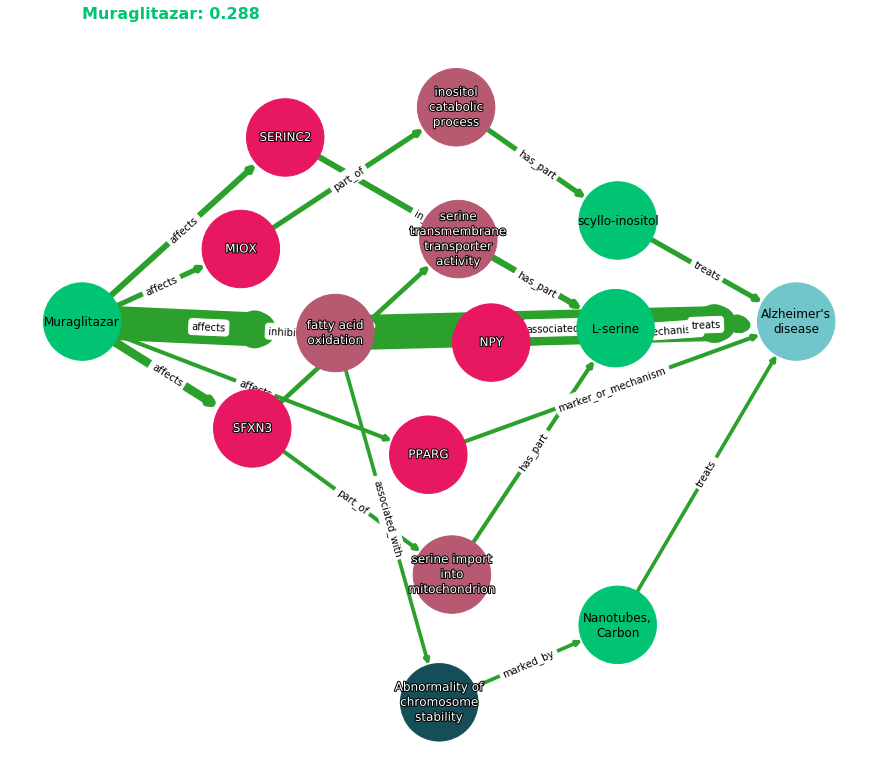

In [63]:
plot_idx(1)

Extracting data for: Oxantel pamoate -TREATS- Alzheimer's disease


100%|██████████| 89/89 [00:00<00:00, 145.03it/s]


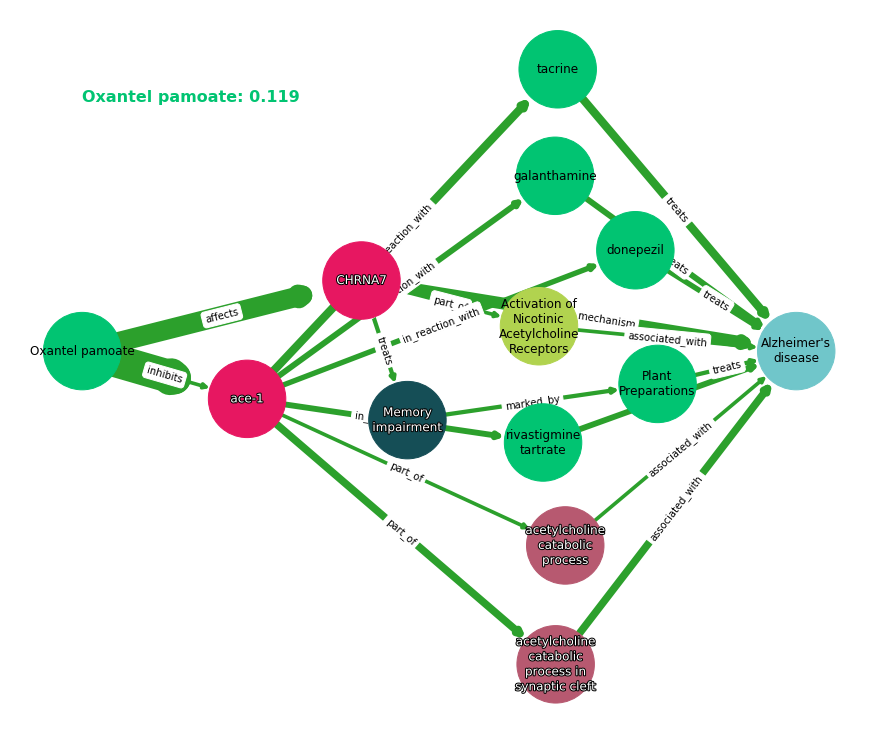

In [64]:
plot_idx(47)

Extracting data for: daidzein -TREATS- Alzheimer's disease


100%|██████████| 89/89 [01:28<00:00,  1.01it/s]


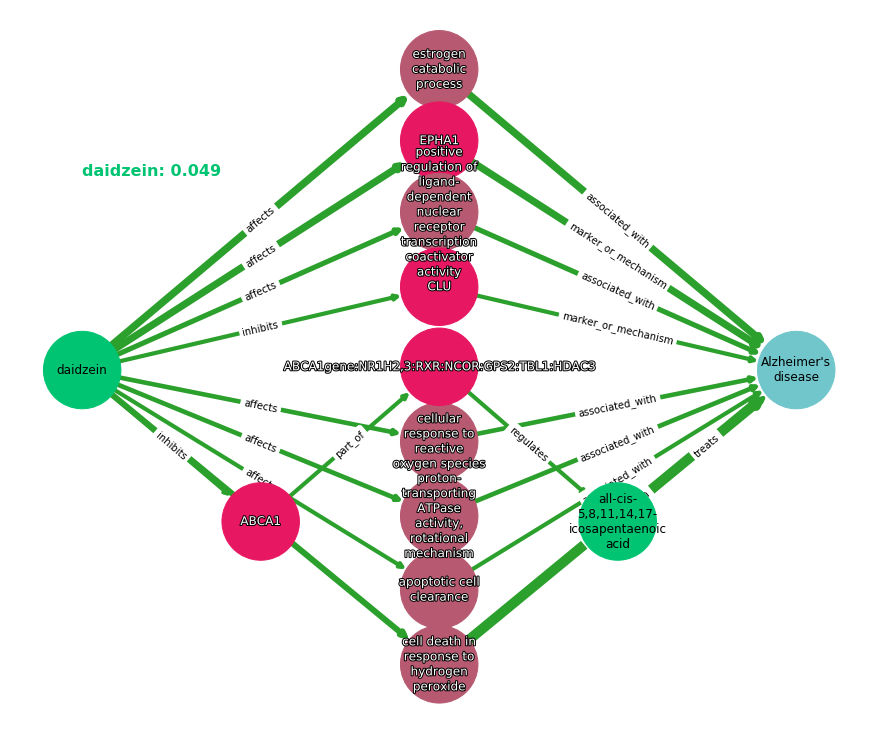

In [60]:
plot_idx(216)

Extracting data for: EMD 53998 -TREATS- Alzheimer's disease


100%|██████████| 89/89 [00:09<00:00,  9.44it/s]


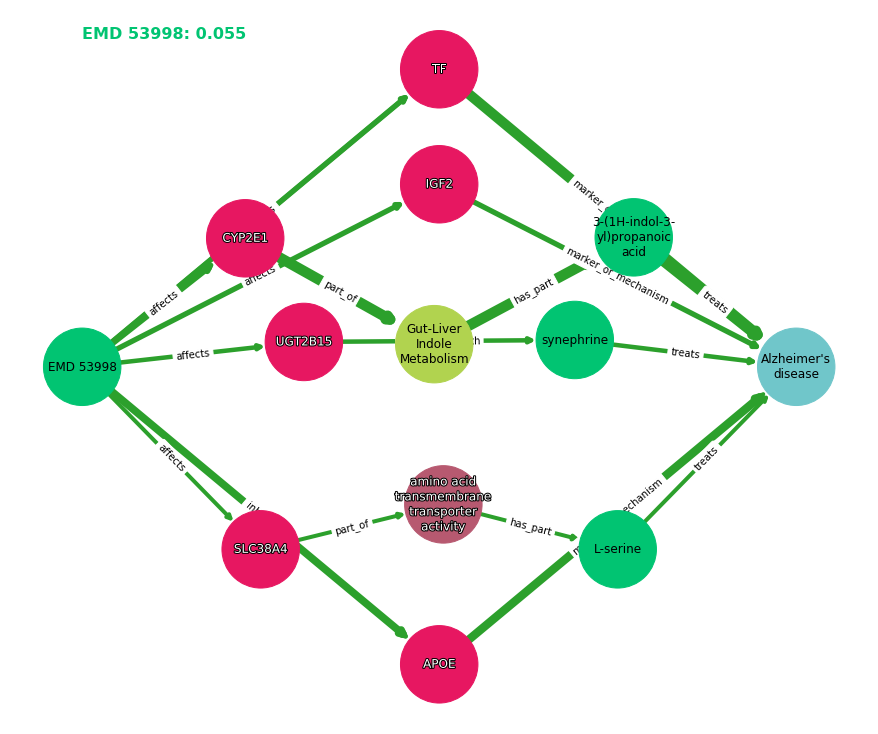

In [61]:
plot_idx(184)

### Get paths for each compound in top 100 and save 100 paths

In [45]:
finished = 0
to_go = 100 - finished

skipped = []

for line in tqdm(ref_pairs.sort_values('proba', ascending=False).head(100).tail(to_go).itertuples(), total=to_go):
    
    try:
        this_res = get_path_info(line.chemicalsubstance_id, line.disease_id)
    except:
        this_res = get_path_info(line.chemicalsubstance_id, line.disease_id, 1)
        
    out_name = line.chemicalsubstance_id.replace(':', '_') + '_' + line.disease_id.replace(':', '_')
    out_name += '_{}.csv'.format(line.proba)

    print(out_dir.joinpath(out_name))
    this_res.sort_values('model_metric', ascending=False).head(100).to_csv(out_dir.joinpath(out_name), index=False)


  1%|          | 1/100 [00:31<52:08, 31.60s/it]

/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_42944_DOID_10652_0.9696804881095886.csv



  2%|▏         | 2/100 [00:58<49:05, 30.06s/it]

/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_41934_DOID_10652_0.8537576794624329.csv



100%|██████████| 113/113 [05:36<00:00,  2.97s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_16240_DOID_10652_0.8431310057640076.csv


100%|██████████| 113/113 [02:42<00:00,  1.44s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_39162_DOID_10652_0.8419374227523804.csv


100%|██████████| 113/113 [00:11<00:00,  9.86it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_48883_DOID_10652_0.8305951952934265.csv


 99%|█████████▉| 112/113 [15:07<02:23, 143.41s/it]Process Process-343:
Traceback (most recent call last):
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/concurrent/futures/process.py", line 181, in _process_worker
    result=r))
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/queues.py", line 347, in put
    self._writer.send_bytes(obj)
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/connection.py", line 393, in _send_bytes
    header = struct.pack("!i", n)
struct.error: 'i

/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_29081_DOID_10652_0.8224026560783386.csv


 98%|█████████▊| 111/113 [14:38<04:46, 143.16s/it]Process Process-378:
Traceback (most recent call last):
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/concurrent/futures/process.py", line 181, in _process_worker
    result=r))
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/queues.py", line 347, in put
    self._writer.send_bytes(obj)
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/connection.py", line 393, in _send_bytes
    header = struct.pack("!i", n)
struct.error: 'i

/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_33216_DOID_10652_0.8129849433898926.csv


100%|██████████| 113/113 [07:04<00:00,  3.76s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_8069_DOID_10652_0.8033419251441956.csv


100%|██████████| 113/113 [17:53<00:00,  9.50s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_27385_DOID_10652_0.8031127452850342.csv


100%|██████████| 113/113 [00:39<00:00,  2.85it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_17941_DOID_10652_0.7822619676589966.csv


100%|██████████| 113/113 [00:45<00:00,  2.47it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_61030_DOID_10652_0.775814414024353.csv


 12%|█▏        | 12/100 [4:55:53<22:28:45, 919.60s/it] 

/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_102524_DOID_10652_0.7728978991508484.csv



 13%|█▎        | 13/100 [4:56:21<15:45:27, 652.04s/it]

/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_2791_DOID_10652_0.7728978991508484.csv



 14%|█▍        | 14/100 [4:56:49<11:06:22, 464.91s/it]

/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_134884_DOID_10652_0.7728978991508484.csv



100%|██████████| 113/113 [00:15<00:00,  7.34it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_6872_DOID_10652_0.7681046724319458.csv


100%|██████████| 113/113 [12:40<00:00,  6.73s/it] 


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_16469_DOID_10652_0.7607341408729553.csv


100%|██████████| 113/113 [04:02<00:00,  2.14s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_8892_DOID_10652_0.7588393688201904.csv


100%|██████████| 113/113 [01:54<00:00,  1.01s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_39462_DOID_10652_0.7566589117050171.csv


100%|██████████| 113/113 [10:13<00:00,  5.43s/it] 


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_28748_DOID_10652_0.7552340626716614.csv


100%|██████████| 113/113 [11:08<00:00,  5.91s/it] 


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_45713_DOID_10652_0.7454646825790405.csv


100%|██████████| 113/113 [00:11<00:00, 10.16it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_6908_DOID_10652_0.7424861192703247.csv


100%|██████████| 113/113 [00:28<00:00,  3.97it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_75704_DOID_10652_0.7416467070579529.csv


100%|██████████| 113/113 [02:00<00:00,  1.06s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_16796_DOID_10652_0.7329180240631104.csv


100%|██████████| 113/113 [01:54<00:00,  1.02s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_30114_DOID_10652_0.7278443574905396.csv


100%|██████████| 113/113 [12:10<00:00,  6.47s/it] 


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_4031_DOID_10652_0.7183195948600769.csv


100%|██████████| 113/113 [07:43<00:00,  4.10s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_8876_DOID_10652_0.7138676047325134.csv


100%|██████████| 113/113 [01:16<00:00,  1.48it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_64323_DOID_10652_0.7103707790374756.csv


 99%|█████████▉| 112/113 [08:41<01:18, 78.43s/it]Process Process-1003:
Traceback (most recent call last):
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/concurrent/futures/process.py", line 181, in _process_worker
    result=r))
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/queues.py", line 347, in put
    self._writer.send_bytes(obj)
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/connection.py", line 393, in _send_bytes
    header = struct.pack("!i", n)
struct.error: 'i

/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_31580_DOID_10652_0.6978361010551453.csv


100%|██████████| 113/113 [03:23<00:00,  1.80s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_33234_DOID_10652_0.6968520283699036.csv


100%|██████████| 113/113 [01:38<00:00,  1.15it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_31271_DOID_10652_0.6939998269081116.csv


100%|██████████| 113/113 [03:00<00:00,  1.59s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_66964_DOID_10652_0.6911332607269287.csv


100%|██████████| 113/113 [02:28<00:00,  1.31s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_42471_DOID_10652_0.677776038646698.csv


100%|██████████| 113/113 [13:58<00:00,  7.42s/it] 


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_53795_DOID_10652_0.6777614951133728.csv


100%|██████████| 113/113 [07:18<00:00,  3.88s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_7790_DOID_10652_0.6764301657676697.csv


 98%|█████████▊| 111/113 [16:05<06:32, 196.40s/it]Process Process-1211:
Traceback (most recent call last):
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/concurrent/futures/process.py", line 181, in _process_worker
    result=r))
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/queues.py", line 347, in put
    self._writer.send_bytes(obj)
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/multiprocessing/connection.py", line 393, in _send_bytes
    header = struct.pack("!i", n)
struct.error: '

/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_39867_DOID_10652_0.6741204857826233.csv


100%|██████████| 113/113 [03:05<00:00,  1.65s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_9288_DOID_10652_0.673001766204834.csv


100%|██████████| 113/113 [02:08<00:00,  1.14s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_16856_DOID_10652_0.6623977422714233.csv


100%|██████████| 113/113 [07:51<00:00,  4.18s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_37537_DOID_10652_0.6621555685997009.csv


100%|██████████| 113/113 [06:24<00:00,  3.40s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_28088_DOID_10652_0.6591935157775879.csv


100%|██████████| 113/113 [01:24<00:00,  1.34it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_16494_DOID_10652_0.6529573202133179.csv


100%|██████████| 113/113 [01:52<00:00,  1.01it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_36560_DOID_10652_0.6406092643737793.csv


100%|██████████| 113/113 [01:35<00:00,  1.19it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_2981_DOID_10652_0.6373258829116821.csv


100%|██████████| 113/113 [02:56<00:00,  1.56s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_34682_DOID_10652_0.6324804425239563.csv


100%|██████████| 113/113 [01:24<00:00,  1.34it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_5855_DOID_10652_0.6284156441688538.csv


100%|██████████| 113/113 [00:29<00:00,  3.77it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_3390_DOID_10652_0.6211087703704834.csv


100%|██████████| 113/113 [07:16<00:00,  3.86s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_41774_DOID_10652_0.6202454566955566.csv


 47%|████▋     | 47/100 [13:21:22<6:09:03, 417.80s/it]

/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_8462_DOID_10652_0.6190081834793091.csv



100%|██████████| 113/113 [01:21<00:00,  1.39it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_16684_DOID_10652_0.616727888584137.csv


100%|██████████| 113/113 [00:10<00:00, 10.86it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_34705_DOID_10652_0.614858865737915.csv


100%|██████████| 113/113 [05:33<00:00,  2.95s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_5819_DOID_10652_0.606399655342102.csv


100%|██████████| 113/113 [09:31<00:00,  5.06s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_41879_DOID_10652_0.6049157381057739.csv


100%|██████████| 113/113 [02:27<00:00,  1.31s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_6801_DOID_10652_0.6039134860038757.csv


100%|██████████| 113/113 [00:17<00:00,  6.31it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_18405_DOID_10652_0.5988170504570007.csv


100%|██████████| 113/113 [01:37<00:00,  1.16it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_44915_DOID_10652_0.5985749959945679.csv


100%|██████████| 113/113 [01:47<00:00,  1.05it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_16112_DOID_10652_0.5984695553779602.csv


 56%|█████▌    | 56/100 [14:20:53<3:05:06, 252.42s/it]

/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_8412_DOID_10652_0.5924277305603027.csv



100%|██████████| 113/113 [03:17<00:00,  1.75s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_94595_DOID_10652_0.5905048251152039.csv


100%|██████████| 113/113 [01:24<00:00,  1.34it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_16204_DOID_10652_0.5852565765380859.csv


100%|██████████| 113/113 [00:15<00:00,  7.23it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_8212_DOID_10652_0.5840882062911987.csv


100%|██████████| 113/113 [00:29<00:00,  3.90it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_63631_DOID_10652_0.5810737013816833.csv


100%|██████████| 113/113 [06:50<00:00,  3.63s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_23414_DOID_10652_0.5764037370681763.csv


100%|██████████| 113/113 [02:01<00:00,  1.08s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_18186_DOID_10652_0.5738621950149536.csv


100%|██████████| 113/113 [02:23<00:00,  1.27s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_27732_DOID_10652_0.5692792534828186.csv


 64%|██████▍   | 64/100 [14:58:42<2:36:13, 260.38s/it]

/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_32010_DOID_10652_0.5692729353904724.csv



100%|██████████| 113/113 [00:18<00:00,  6.07it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_48723_DOID_10652_0.5637712478637695.csv


100%|██████████| 113/113 [04:32<00:00,  2.41s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_17823_DOID_10652_0.5631071925163269.csv


100%|██████████| 113/113 [00:24<00:00,  4.63it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_18305_DOID_10652_0.5625876188278198.csv


100%|██████████| 113/113 [01:11<00:00,  1.57it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_50202_DOID_10652_0.5619086623191833.csv


100%|██████████| 113/113 [07:38<00:00,  4.06s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_30621_DOID_10652_0.5612964034080505.csv


100%|██████████| 113/113 [02:37<00:00,  1.40s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_63041_DOID_10652_0.561066746711731.csv


100%|██████████| 113/113 [00:21<00:00,  5.33it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_90972_DOID_10652_0.5574902892112732.csv


100%|██████████| 113/113 [03:07<00:00,  1.66s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_31823_DOID_10652_0.5524723529815674.csv


100%|██████████| 113/113 [01:35<00:00,  1.18it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_94583_DOID_10652_0.552250862121582.csv


100%|██████████| 113/113 [02:48<00:00,  1.49s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_51384_DOID_10652_0.5495226979255676.csv


100%|██████████| 113/113 [02:09<00:00,  1.14s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_41423_DOID_10652_0.5466163158416748.csv


100%|██████████| 113/113 [02:06<00:00,  1.12s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_51064_DOID_10652_0.5439468622207642.csv


100%|██████████| 113/113 [01:36<00:00,  1.17it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_3385_DOID_10652_0.5408748984336853.csv


100%|██████████| 113/113 [00:22<00:00,  4.99it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_6741_DOID_10652_0.5401491522789001.csv


100%|██████████| 113/113 [06:08<00:00,  3.26s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_8502_DOID_10652_0.5388802886009216.csv


100%|██████████| 113/113 [03:53<00:00,  2.07s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_44185_DOID_10652_0.5353668928146362.csv


100%|██████████| 113/113 [00:29<00:00,  3.87it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_15854_DOID_10652_0.5278439521789551.csv


100%|██████████| 113/113 [02:16<00:00,  1.21s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_38576_DOID_10652_0.5231178402900696.csv


 83%|████████▎ | 83/100 [16:45:30<1:11:07, 251.02s/it]

/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/IKEY_XEAOPVUAMONVLA-QGZVFWFLSA-N_DOID_10652_0.5229278802871704.csv



100%|██████████| 113/113 [04:55<00:00,  2.61s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_27470_DOID_10652_0.5216857194900513.csv


100%|██████████| 113/113 [01:04<00:00,  1.75it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_71365_DOID_10652_0.5175369381904602.csv


100%|██████████| 113/113 [02:07<00:00,  1.13s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_6121_DOID_10652_0.5104156136512756.csv


100%|██████████| 113/113 [00:53<00:00,  2.13it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_16794_DOID_10652_0.5078573226928711.csv


100%|██████████| 113/113 [00:10<00:00, 10.36it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_31827_DOID_10652_0.5067679286003113.csv


100%|██████████| 113/113 [07:20<00:00,  3.90s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_49662_DOID_10652_0.5026201009750366.csv


100%|██████████| 113/113 [02:42<00:00,  1.44s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_82864_DOID_10652_0.4871199131011963.csv


100%|██████████| 113/113 [00:09<00:00, 11.97it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_8028_DOID_10652_0.4867829978466034.csv


100%|██████████| 113/113 [01:23<00:00,  1.35it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_33118_DOID_10652_0.48570331931114197.csv


100%|██████████| 113/113 [02:26<00:00,  1.30s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_144353_DOID_10652_0.4855723977088928.csv


100%|██████████| 113/113 [06:37<00:00,  3.52s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_3387_DOID_10652_0.4832876920700073.csv


100%|██████████| 113/113 [00:12<00:00,  9.41it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_32243_DOID_10652_0.4825443625450134.csv


100%|██████████| 113/113 [02:23<00:00,  1.27s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_65329_DOID_10652_0.48213163018226624.csv


100%|██████████| 113/113 [02:37<00:00,  1.40s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_4806_DOID_10652_0.481209397315979.csv


100%|██████████| 113/113 [01:30<00:00,  1.25it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_77568_DOID_10652_0.4752993583679199.csv


100%|██████████| 113/113 [00:45<00:00,  2.47it/s]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_31530_DOID_10652_0.4750608801841736.csv


100%|██████████| 113/113 [03:08<00:00,  1.67s/it]


/opt/mmayers/projects/metapaths/2_pipeline/14e_Model_results_analysis_alzheimers/out/ref_alz/CHEBI_16602_DOID_10652_0.47435009479522705.csv


100%|██████████| 100/100 [18:17:25<00:00, 658.45s/it]


### Save images of top 10 paths for each of the top 100 compounds

In [46]:
from data_tools.df_processing import strip_special_chars

In [47]:
import warnings
warnings.simplefilter('ignore')

In [49]:
import matplotlib.pyplot as plt

In [50]:
img = out_dir.joinpath('img')
img.mkdir(exist_ok=True, parents=True)

for f in out_dir.iterdir():
    if f.name.endswith('.csv'):

        prob = float(f.name.split('_')[-1].rstrip('.csv'))
        path_info = pd.read_csv(f, converters={'nodes': eval, 'node_ids': eval}).head(10)
        d_name = path_info.loc[0, 'nodes'][0]
        d_name = strip_special_chars(d_name.lower().replace(' ', '_'))
        
        draw_top_paths(path_info, 10, proba=prob)

        plt.savefig(img.joinpath('{}_{:1.3f}.png'.format(d_name, prob)), dpi=300)
        plt.clf()

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>